# University of Maryland Center for Advanced Lifecycle Engineering
## Applications of Big Data in Prognostics & Health Management

![calce Logo](http://www.calce.umd.edu/images/CALCE_RED.gif)


## Analysis of the 2008 PHM Data Set Using Standard PyData Stack

### Presented by John Patanian, Principal Engineer GE Power
### October 2, 2016


# Abstract

The purpose of this Jupyter notebook is to demonstrate a typical anomaly detection of an using industrial time series data using the standard scientific Python tools stack.  This will serve as a baseline comparison to the Apache Spark version, which can scale to a much larger than memory data set.

The dataset comes from the 2008 PHM Data Challenge, and consists a dataset of multiple parameters from a jet engine. The dataset includes data from several jet engines of a similar design and includes data for three different settings, as well as about 21 sensor readings. 

For more information on the dataset, please refer to  [PHM 2008 Data Challenge Data Set Documentation](https://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#phm08_challenge).

In this notebook, we will do pre-processing of the data using the scientific Python stack, which includes pandas, numpy and matplotlib.  This will provide exposure to several data preprocessing an analysis techniques that are commonly applies to analyses in the context of a PHM application.

In [112]:
# This makes it so that matplotlib graphics will show up within the Jupyter Notebook.
%matplotlib inline

# Standard library import

# Data Analysis Tools
import pandas as pd
import numpy as np

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Tools
import sklearn
import sklearn.mixture as mix
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (10, 10)

def get_sensor_names(tag_names):
    """ Get tagnames starting with sensor.
    
    :param tag_names: Input time series data frame
    
    :return list of string tag names starting with sensor.
    """
    
    return [tag_name for tag_name in tag_names if tag_name.startswith('sensor')]

## Data Set Description

The data set is in text file format, with spaces used to separate the columns. The data set includes no headers. Column names are defined in the data set documentation, and are shown below for reference.

Variables | Description
----------|------------
unit | Asset Identification
cycle_num | Time or flight based ordinal
setting1 | Unknown Operational setting 
setting2 | Unknown Operational setting 
setting3 | Unknown Operational setting 
sensor1 | Sensor time series reading1
... | ...
sensor21 | Sensor time series reading21
 
The three columns, *setting1*, *setting2*, and *setting3*, represent operational settings on the engine, and the columns 'senor1' through 'sensor3' are time series readings from unidentified sensors. We are first going to examine the settings columns. The describe functions provides summary type information on a numeric series.


## Step 1: Data Import

Uses the pandas 'read.csv' method with options to handle how this dataset is formatted (separated by spaces, no header is present.)

In [113]:
#Tag Names provided in data set description
tag_names = ['unit','cycle_num', 'setting1','setting2',
         'setting3', 'sensor1', 'sensor2',
         'sensor3', 'sensor4', 'sensor5', 'sensor6',
         'sensor7', 'sensor8', 'sensor9', 'sensor10',
         'sensor11', 'sensor12', 'sensor13', 'sensor14',
         'sensor15', 'sensor16', 'sensor17', 'sensor18',
         'sensor19', 'sensor20', 'sensor21']

sensor_columns = get_sensor_names(tag_names)
train_data = pd.read_csv('train.txt', sep='\s+', header=None, names=tag_names)

## Step 2: Data Exploration

In [114]:
train_data.head()

,unit,cycle_num,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [115]:
train_data.shape

(45918, 26)

In [116]:
train_data.describe()

,unit,cycle_num,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
count,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,...,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000,45918.000000
mean,109.396511,110.307396,24.008881,0.571251,49.172438,472.861677,579.596770,1419.947816,1205.669194,8.029878,...,265.943344,2334.185381,8065.548831,9.332433,0.023354,348.293915,2228.342654,97.741699,20.776822,12.466282
std,62.866193,68.420545,14.793676,0.310935,32.503659,26.460179,37.391068,106.286960,119.550936,3.627125,...,138.163656,128.426495,84.964099,0.751834,0.004722,27.837602,145.693883,5.378969,9.903697,5.941954
min,1.000000,1.000000,0.000000,0.000000,0.000000,445.000000,535.650000,1245.430000,1029.490000,3.910000,...,129.240000,2027.720000,7851.590000,8.325300,0.020000,303.000000,1915.000000,84.930000,10.230000,6.126600
25%,54.000000,53.000000,10.004500,0.250600,20.000000,445.000000,549.580000,1352.910000,1124.010000,3.910000,...,131.360000,2387.880000,8061.230000,8.676925,0.020000,331.000000,2212.000000,100.000000,10.840000,6.504600
50%,110.000000,106.000000,25.001500,0.700000,40.000000,462.540000,555.985000,1369.140000,1138.870000,7.050000,...,183.170000,2388.070000,8081.475000,9.314500,0.020000,335.000000,2223.000000,100.000000,14.870000,8.925200
75%,164.000000,160.000000,41.998100,0.840000,80.000000,491.190000,607.370000,1499.697500,1307.437500,10.520000,...,371.250000,2388.160000,8126.380000,9.390000,0.030000,369.000000,2324.000000,100.000000,28.470000,17.084200
max,218.000000,357.000000,42.008000,0.842000,100.000000,518.670000,644.430000,1614.660000,1442.360000,14.620000,...,523.460000,2390.740000,8274.880000,11.082600,0.030000,398.000000,2388.000000,100.000000,39.330000,23.590500


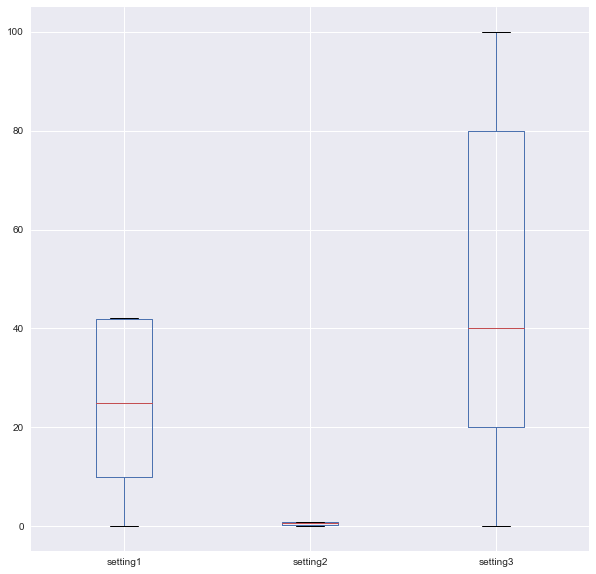

In [117]:
train_data[['setting1', 'setting2', 'setting3']].plot(kind='box');

As you can see above, setting1 and setting 3 are reasonably close to the same range, but the range of values of setting 2 is about 1/100th of the size of setting3.

Below we also look at the just the settings data, scale the data using a z-score type scaling method and then view via a scatterplot matrix type plot.

*subset by ['setting', 'setting2', 'setting3']

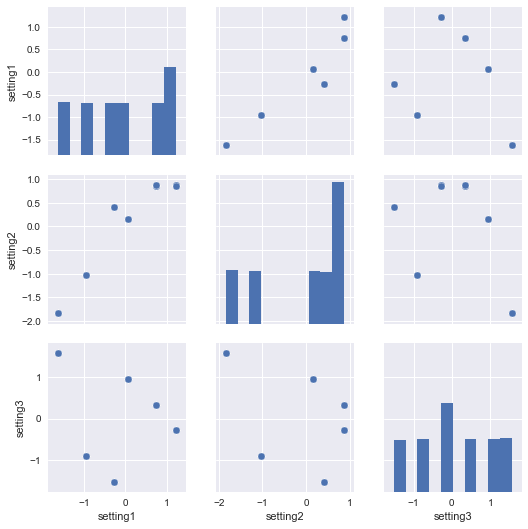

In [118]:
scaled_settings = train_data[['setting1', 'setting2', 'setting3']].apply(scale, axis=0)

sns.pairplot(scaled_settings)

Since this is a plot of over 45000 points, it is obvious that the settings fall neatly into  one of about six bins. Each setting could certainly be easily manually discretized and transformed into a categorical or ordinal variable, especially if there was domain knowledge provided about what each of the settings mean.

## Clustering of the settings parameters

Below we will cluster the settings data using KMeans clustering. To find the optimum number of clusters, we calculate the Silhouette score for each choice of number of clusters. The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Note that calculation of the silhouette score is computationally expensive, thus the used of the sample_size argument in the next cell.



In [119]:
scores= []
cluster_sizes = range(2,10)

#Set a seed value for the random number enerator to get repeatable results
np.random.seed(10)

for num_clusters in cluster_sizes:
    labels = KMeans(n_clusters=num_clusters, 
                    n_init=20, 
                    max_iter=1000).fit_predict(scaled_settings)
    
    silh_score = silhouette_score(scaled_settings.values, labels, sample_size=2000)
    scores.append(silh_score)

## Select the cluster size with the best Silhouette Score

In [120]:
print('Optimimum Cluster size = {}'.format(cluster_sizes[np.argmax(scores)]))
chosen_cluster_size

Optimimum Cluster size = 6


6

The plot of the Silhouette score on the y-axis versus the number of clusters on the x-axis shows that the ideal number of clusters is 6. The score of 1.0 indicates that the settings are completely separable into 6 clusters using the k-means algorithm.

We will replace the 3 individual settings columns, with a new column titled *overall_setting* and set it to a categorical type. We can only do this beause within an individual settings group there the values for the individual settings are nearly identical.

For a real problem, it would be important to understand if either physically or through the control scheme these settings are contstrained as we have binned them.

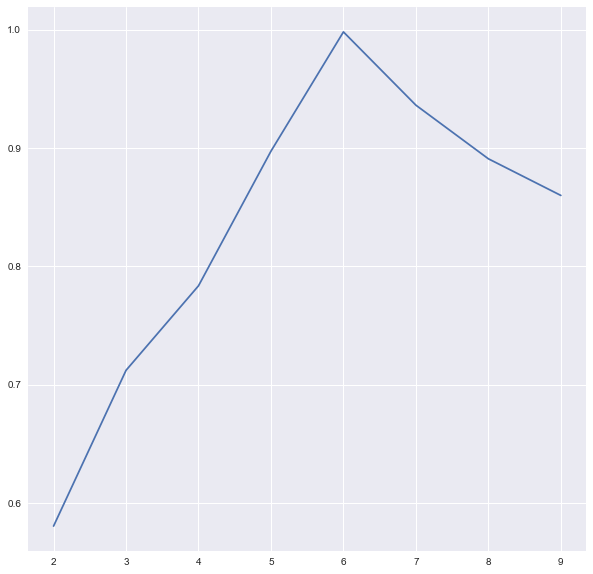

In [121]:
plt.plot(cluster_sizes, scores)

predictions = KMeans(n_clusters=chosen_cluster_size).fit_predict(scaled_settings)

train_data['overall_setting'] = predictions
train_data.drop(['setting1', 'setting2', 'setting3'], axis=1, inplace=True)
train_data['overall_setting']= train_data['overall_setting'].astype('category')

In [122]:
sensor_names = get_sensor_names(tag_names)

## Data Quality Checks

A common data quality check is to look for parameters with zero variance.  We can use built-in pandas functionality to do this. Note that wea are computing variance for each distinct value of the categorical variable we created earlier.

We will then automatically drop variables from our data set having zero variance.


In [123]:
def is_zero(series):
    return series == 0

variance_by_setting = train_data[sensor_names + ['overall_setting']].groupby('overall_setting').var()
sensor_variance = variance_by_setting.apply(is_zero, axis=0).all()
sensor_variance

sensor1      True
sensor2     False
sensor3     False
sensor4     False
sensor5      True
sensor6     False
sensor7     False
sensor8     False
sensor9     False
sensor10    False
sensor11    False
sensor12    False
sensor13    False
sensor14    False
sensor15    False
sensor16    False
sensor17    False
sensor18     True
sensor19     True
sensor20    False
sensor21    False
dtype: bool

In [124]:
# Generate a list of the sensors with zero variance.
sensor_drop_list=sensor_variance[sensor_variance].index.values

# Drop these sensors from the training_data
train_data_subset = train_data.drop(sensor_drop_list, axis=1, inplace=False)

## Drop columns with high correlation

In this dataset, there are several highly correlated variables. Often, depending on the modeling techniques used, it is advantageous to drop one of the two correlated variables, such that there are no variables remaining that have a correlation with another variable in the data set higher than a threshold value.

For demonstration purposes here, we are going to set the threshold value to 0.99.

In [134]:
sensor_names = get_sensor_names(train_data_subset)

train_data_subset[sensor_names].corr()

#Note below was determined visually
high_corr_cols = ['sensor3','sensor4','sensor6',
                  'sensor7','sensor12','sensor17',
                  'sensor20']
high_corr_cols

corr = train_data[sensor_names].corr()
corr[(corr > 0.99) & (corr < 1.0)]

,sensor2,sensor3,sensor4,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor20,sensor21
sensor2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor3,NaN,NaN,NaN,NaN,NaN,NaN,0.997816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998687,NaN,NaN
sensor4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990403,NaN,NaN
sensor6,NaN,NaN,NaN,NaN,0.993276,NaN,NaN,NaN,NaN,0.993108,NaN,NaN,NaN,NaN,NaN,0.996369,0.996361
sensor7,NaN,NaN,NaN,0.993276,NaN,NaN,NaN,NaN,NaN,0.999993,NaN,NaN,NaN,NaN,NaN,0.999144,0.999146
sensor8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor9,NaN,0.997816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997865,NaN,NaN
sensor10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sensor12,NaN,NaN,NaN,0.993108,0.999993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999087,0.999090


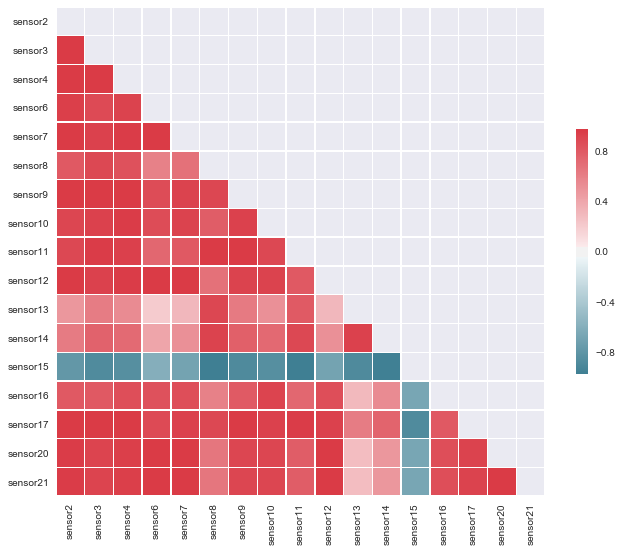

In [90]:
def plot_corr_heatmap(corr_matrix):
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
# Compute the correlation matrix
corr = train_data_subset[sensor_names].corr()
plot_corr_heatmap(corr)


In [91]:
train_data_subset = train_data_subset.drop(high_corr_cols, axis=1, inplace=False) 

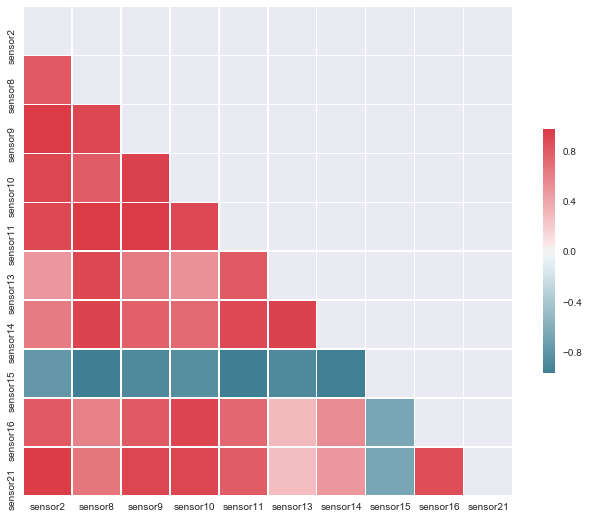

In [92]:
sensor_names = get_sensor_names(train_data_subset)

corr = train_data_subset[sensor_names].corr()
plot_corr_heatmap(corr)